<h1> Main ALM-analysis</h1>

<h2>Summary:</h2>

|Investment Strategy|	SCR (Var_95%(delta BOF))	|Median BOF [kr]|	Insolvency Probability [%]|	∆BOF 2008|
|---|---|---|---|---|
|a) BH(0/100)|	46 594|	175 248	|11.5|	-58 956 |
|b) BH(50/50)|	331 981|	2 411 073|	25.9	|-550 742 |
|c) CM(50/50)	|333 037|	1 749 109|	25.35|	|
|d) CM(50/50)-Duratio|	282 783|	1 898 350	|17.85| |


In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from makeham import makeham
from firstOrder import firstOrder
from secondOrder2 import secondOrder2
from portfolio import portfolio
from scenarioHandler import scenarioHandler
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Estimating Makeham Parameters
xls = pd.ExcelFile(r'estFOM.xlsx')
parametersDF = pd.read_excel(xls, 'export')
estFOMFemale = parametersDF['Force of Mortality (W)'].values
estFOMFemale = estFOMFemale[:71]
ages = np.arange(20,91)

femaleMakeham = makeham(estFOMFemale,ages)
makehamParameters = femaleMakeham.parameters

In [9]:
# Settings
age0 = 60
z = 65
s = 120
V0 = 2600000
G0 = 2000000

n = 2000

<h2>Implement an ALM-model</h2>

In [10]:
# Create scenario
oneScenario = pd.read_csv('data/OneScenario.csv',index_col=0)
scenario = scenarioHandler(oneScenario)

In [11]:
# First Order
firstOrderDept = firstOrder(G0, age0, makehamParameters)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(scenario,360)
BE = firstOrderDept.be

In [12]:
# Second Order
values = np.ones(len(scenario.stocks)) *(V0/len(scenario.stocks))
stockPortfolio = portfolio(values,0,scenario)
secondOrderDept = secondOrder2(V0, age0, makehamParameters, stockPortfolio, expFirstReserve)

assets = secondOrderDept.assets
expSecondReserve = secondOrderDept.expSecondOrderReserve
BOF = assets-BE

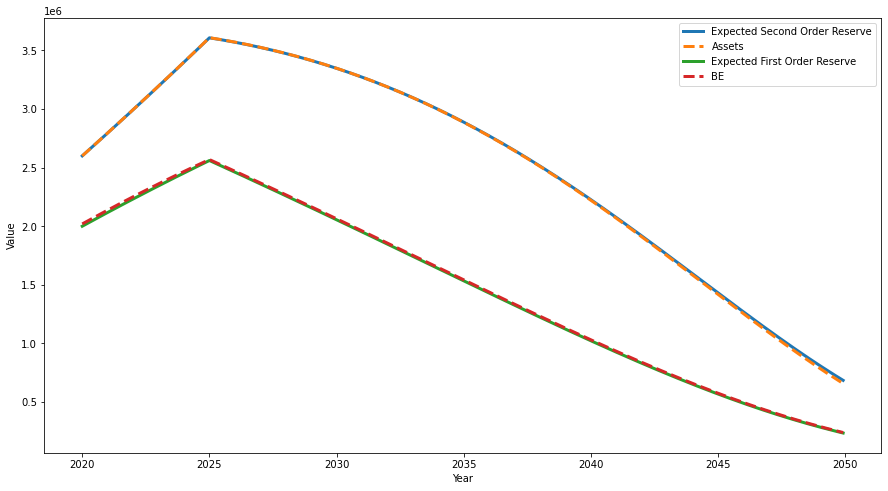

In [13]:
# Plot Values/Evolutions
plt.rcParams['figure.figsize'] = [15, 8]
x = np.arange(2020,2050,(1/12))
plt.plot(x,expSecondReserve,label='Expected Second Order Reserve',linewidth=3)
plt.plot(x,assets,'--',label='Assets',linewidth=3)
plt.plot(x,expFirstReserve,label='Expected First Order Reserve',linewidth=3)
plt.plot(x,BE,'--',label='BE',linewidth=3)
#plt.plot(x,BOF,'--',label='BOF',linewidth=3)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()

table = np.zeros((4,3))
for i in range(0,3):
    table[0,i] = np.ceil(expSecondReserve[i*60])
    table[1,i] = np.ceil(assets[i*60])
    table[2,i] = np.ceil(expFirstReserve[i*60])
    table[3,i] = np.ceil(BE[i*60])

# print(table)

| Time [Months after 2020-01-01] | E[G] | BE | E[V] | Assets | 
| --- | --- | --- | --- | --- |
| 0 | 2000000 | 2008367 | 2600000 | 2600000 |
| 30 | 2560535 | 2561665 | 3607248 | 3598277 |
| 60 | 2055103 | 2059485 | 3323414 | 3311738 |

<h2>ALM-analysis</h2>

In [14]:
# Create scenarios
scenariosDF = pd.read_csv('data/ScenarioFile.csv',index_col=0)
scenarios = scenarioHandler(scenariosDF)
scenarios.split()
allScenarios = scenarios.scenarioArray

In [15]:
# BOF using BH(0/100)
BOFa = np.zeros((len(allScenarios[:n]),max(allScenarios[1].periods)))
i = 0
firstOrderDept2 = firstOrder(G0, age0, makehamParameters, maxT=120)

for scenariot in tqdm(allScenarios[:n]):

    firstOrderDept2.getBE2(scenariot)
    BE = firstOrderDept2.be

    bondPortfolio = portfolio(V0,0,scenariot,strategy='a')
    secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
    assets = secondOrderDept.assets

    BOFa[i,:] = assets - BE
    i+=1

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
# BOF using BH(50/50)
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])
BOFb = np.zeros((len(allScenarios[:n]),max(allScenarios[1].periods)))
i = 0
firstOrderDept2 = firstOrder(G0, age0, makehamParameters, maxT=120)

for scenariot in tqdm(allScenarios[:n]):

    firstOrderDept2.getBE2(scenariot)
    BE = firstOrderDept2.be

    Portfolio = portfolio(values,0,scenariot,strategy='b')
    secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=120)
    assets = secondOrderDept.assets

    BOFb[i,:] = assets - BE
    i+=1

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
# BOF using CM(50/50)
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])
BOFc = np.zeros((len(allScenarios[:n]),max(allScenarios[1].periods)))
i = 0
firstOrderDept2 = firstOrder(G0, age0, makehamParameters, maxT=120)

for scenariot in tqdm(allScenarios[:n]):

    firstOrderDept2.getBE2(scenariot)
    BE = firstOrderDept2.be

    Portfolio = portfolio(values,0,scenariot,strategy='c')
    secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=120)
    assets = secondOrderDept.assets

    BOFc[i,:] = assets - BE
    i+=1

  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
# BOF using CM(50/50)-Duration
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])
BOFd = np.zeros((len(allScenarios[:n]),max(allScenarios[1].periods)))
i = 0
firstOrderDept2 = firstOrder(G0, age0, makehamParameters, maxT=120)
firstOrderDept2.getBE()
durationBE = firstOrderDept2.beD

for scenariot in tqdm(allScenarios[:n]):

    firstOrderDept2.getBE2(scenariot)
    BE = firstOrderDept2.be

    Portfolio = portfolio(values,0,scenariot,strategy='d',duration=durationBE)
    secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=120)
    assets = secondOrderDept.assets

    BOFd[i,:] = assets - BE
    i+=1

  0%|          | 0/2000 [00:00<?, ?it/s]

<h3>SCR<h3>

In [19]:
deltaBOFa = []
for i in range(n):
    deltaBOFa.append(BOFa[i][11]-BOFa[i][0])

deltaBOFa.sort()
SRCa = -np.quantile(deltaBOFa,0.05)

deltaBOFb = []
for i in range(n):
    deltaBOFb.append(BOFb[i][11]-BOFb[i][0])
deltaBOFb.sort()
SRCb = -np.quantile(deltaBOFb,0.05)

deltaBOFc = []
for i in range(n):
    deltaBOFc.append(BOFc[i][11]-BOFc[i][0])
deltaBOFc.sort()
SRCc = -np.quantile(deltaBOFc,0.05)

deltaBOFd = []
for i in range(n):
    deltaBOFd.append(BOFd[i][11]-BOFd[i][0])
deltaBOFd.sort()
SRCd = -np.quantile(deltaBOFd,0.05)

#print(SRCa,SRCb,SRCc,SRCd)

| Investment Strategy	|SCR (Var_95%(delta BOF)) |
| --- | --- |
| a) BH(0/100)|	46 594|
|b) BH(50/50)|	331 981|
|c) CM(50/50)	|333 037|
|d) CM(50/50)-Duratio|	282 783 |

<h3>median – insolvency probability Diagram:</h3>

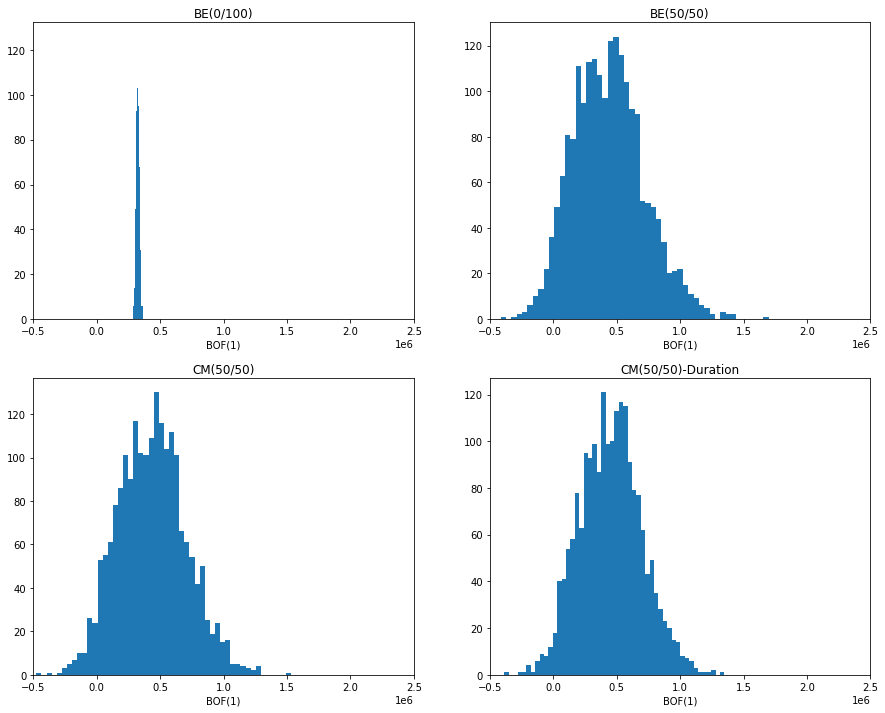

In [20]:
plt.rcParams['figure.figsize'] = [15,12]
fig, axs = plt.subplots(2, 2)

axs[0,0].hist(BOFa[:,11], bins=50)
axs[0,0].set_xlim(-500000,2500000)
axs[0,0].set_title('BE(0/100)')
axs[0,0].set_xlabel('BOF(1)')

axs[0,1].hist(BOFb[:,11], bins=50)
axs[0,1].set_xlim(-500000,2500000)
axs[0,1].set_title('BE(50/50)')
axs[0,1].set_xlabel('BOF(1)')

axs[1,0].hist(BOFc[:,11], bins=50)
axs[1,0].set_xlim(-500000,2500000)
axs[1,0].set_title('CM(50/50)')
axs[1,0].set_xlabel('BOF(1)')

axs[1,1].hist(BOFd[:,11], bins=50)
axs[1,1].set_xlim(-500000,2500000)
axs[1,1].set_title('CM(50/50)-Duration')
axs[1,1].set_xlabel('BOF(1)')

plt.show()

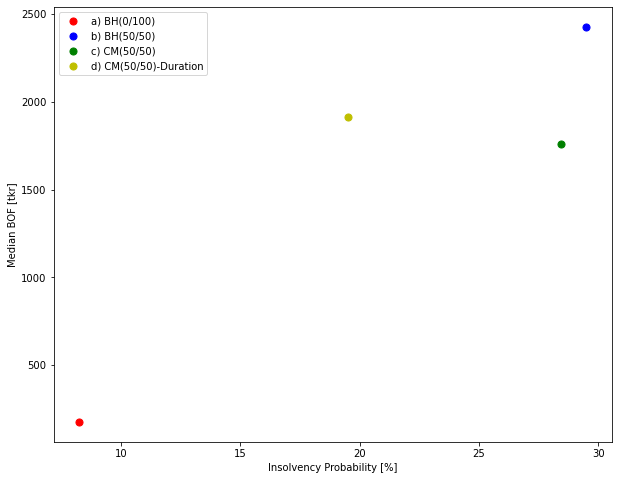

In [21]:
# insolvency probabilities

insolvencyProb = []

BOFaSolv = BOFa[np.all(BOFa > 0, axis=1)]
insolvencyProb.append((len(BOFa)-len(BOFaSolv))/len(BOFa))

BOFbSolv = BOFb[np.all(BOFb > 0, axis=1)]
insolvencyProb.append((len(BOFb)-len(BOFbSolv))/len(BOFb))

BOFcSolv = BOFc[np.all(BOFc > 0, axis=1)]
insolvencyProb.append((len(BOFc)-len(BOFcSolv))/len(BOFc))

BOFdSolv = BOFd[np.all(BOFd > 0, axis=1)]
insolvencyProb.append((len(BOFd)-len(BOFdSolv))/len(BOFd))

# median BOF
#print(insolvencyProb)

medianBOFs = [np.median(BOFaSolv[:,119]),np.median(BOFbSolv[:,119]),np.median(BOFcSolv[:,119]),np.median(BOFdSolv[:,119])]
#print(medianBOFs)

# Scatterplot
labels = ['a) BH(0/100)','b) BH(50/50)','c) CM(50/50)','d) CM(50/50)-Duration']
plt.rcParams['figure.figsize'] = [10,8]
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'y'}
fig, axs = plt.subplots()
for i in range(4):
    axs.scatter(insolvencyProb[i]*100, medianBOFs[i]/1000, c = cdict[i], label = labels[i], s = 50)
axs.legend()
axs.set_xlabel('Insolvency Probability [%]')
axs.set_ylabel('Median BOF [tkr]')
plt.show()

| Investment Strategy | Median BOF [kr] | Insolvency Probability [%] |
| --- | --- | -- |
| a) BH(0/100) |175 248 | 11.5 |
| b) BH(50/50)|	2 411 073|	25.9 |
| c) CM(50/50)|	1 749 109|	25.35 |
| d) CM(50/50)-Duratio|	1 898 350	|17.85 |

<h2>Visualization of Scenarios 3 and 4:</h2>
<h3>a) BH(0/100)</h3>

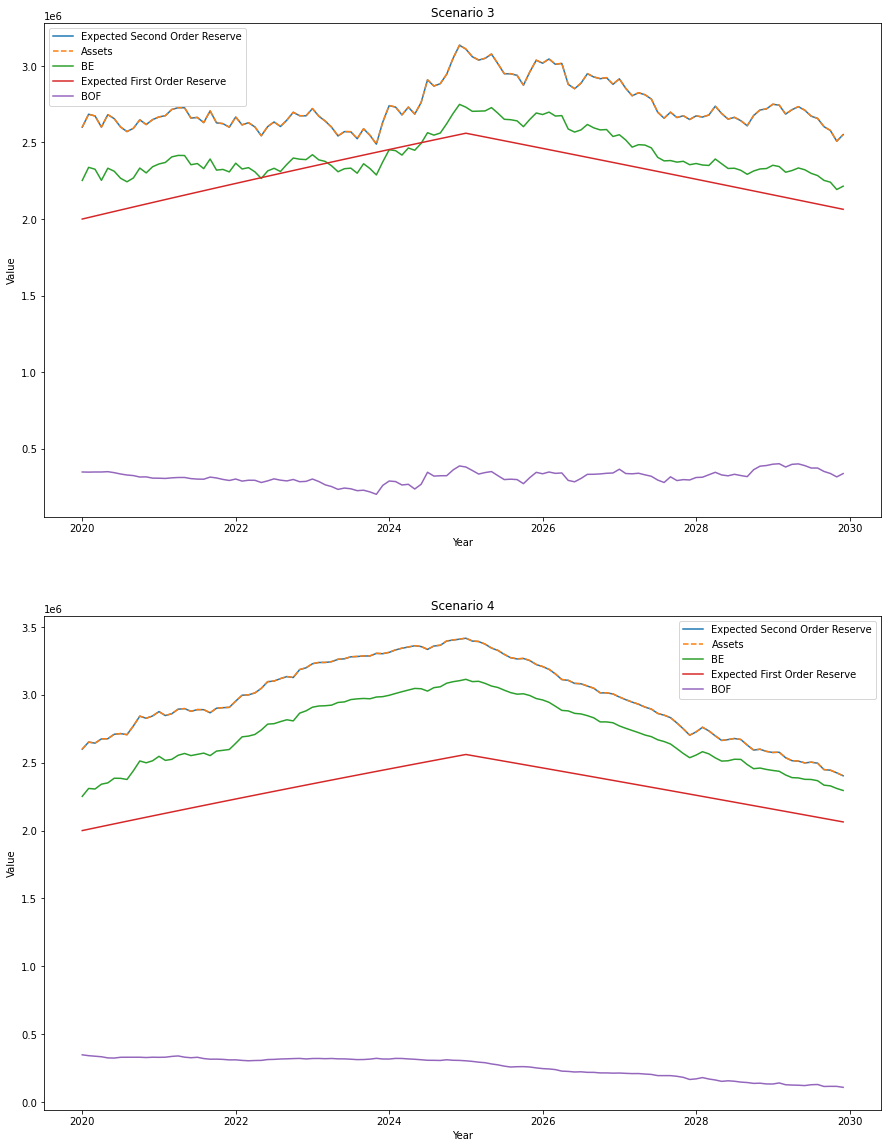

In [22]:
## Visualize scenarios BH(0/100)

firstOrderDept = firstOrder(G0, age0, makehamParameters, maxT=120)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(allScenarios[2])
BE3 = firstOrderDept.be

bondPortfolio = portfolio(V0,0,allScenarios[2],strategy='a')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets3 = secondOrderDept.assets
expSecondReserve3 = secondOrderDept.expSecondOrderReserve
BOF3 = assets3-BE3

firstOrderDept.getBE2(allScenarios[3])
BE4 = firstOrderDept.be

bondPortfolio = portfolio(V0,0,allScenarios[3],strategy='a')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets4 = secondOrderDept.assets
expSecondReserve4 = secondOrderDept.expSecondOrderReserve
BOF4 = assets4-BE4

plt.rcParams['figure.figsize'] = [15,20]
fig, axs = plt.subplots(2, 1)

x = np.arange(2020,2030,(1/12))
axs[0].plot(x,expSecondReserve3,label='Expected Second Order Reserve')
axs[0].plot(x,assets3,'--',label='Assets')
axs[0].plot(x,BE3,label='BE')
axs[0].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[0].plot(x,BOF3,label='BOF')
axs[0].set_title('Scenario 3')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Value')
axs[0].legend()

axs[1].plot(x,expSecondReserve4,label='Expected Second Order Reserve')
axs[1].plot(x,assets4,'--',label='Assets')
axs[1].plot(x,BE4,label='BE')
axs[1].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[1].plot(x,BOF4,label='BOF')
axs[1].set_title('Scenario 4')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Value')
axs[1].legend()

plt.show()

<h3>b) BH(50/50)</h3>

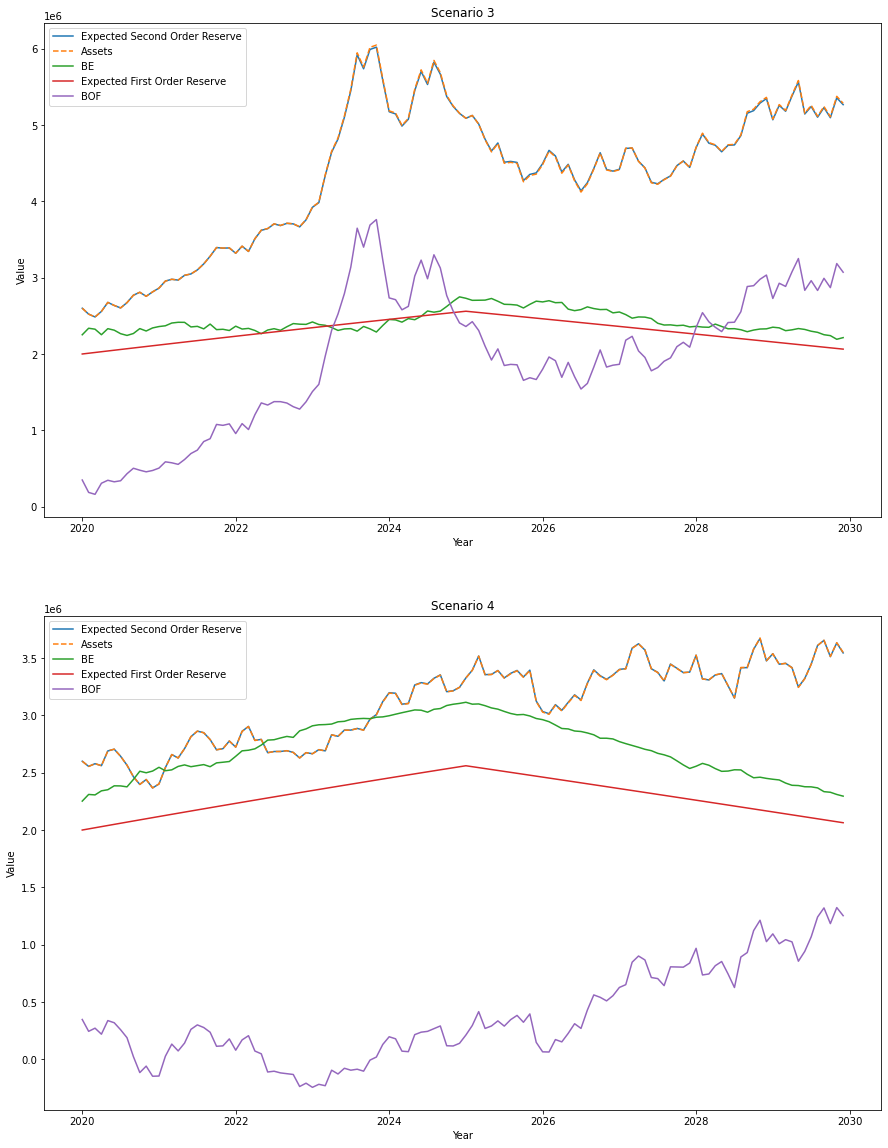

In [23]:
## Visualize scenarios BH(50/50)
# 3
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])

firstOrderDept = firstOrder(G0, age0, makehamParameters, maxT=120)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(allScenarios[2])
BE3 = firstOrderDept.be

Portfolio = portfolio(values,0,allScenarios[2],strategy='b')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=120)
assets3 = secondOrderDept.assets
expSecondReserve3 = secondOrderDept.expSecondOrderReserve
BOF3 = assets3-BE3

# 4
firstOrderDept.getBE2(allScenarios[3])
BE4 = firstOrderDept.be

Portfolio = portfolio(values,0,allScenarios[3],strategy='b')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=120)
assets4 = secondOrderDept.assets
expSecondReserve4 = secondOrderDept.expSecondOrderReserve
BOF4 = assets4-BE4

fig, axs = plt.subplots(2, 1)

x = np.arange(2020,2030,(1/12))
axs[0].plot(x,expSecondReserve3,label='Expected Second Order Reserve')
axs[0].plot(x,assets3,'--',label='Assets')
axs[0].plot(x,BE3,label='BE')
axs[0].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[0].plot(x,BOF3,label='BOF')
axs[0].set_title('Scenario 3')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Value')
axs[0].legend()

axs[1].plot(x,expSecondReserve4,label='Expected Second Order Reserve')
axs[1].plot(x,assets4,'--',label='Assets')
axs[1].plot(x,BE4,label='BE')
axs[1].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[1].plot(x,BOF4,label='BOF')
axs[1].set_title('Scenario 4')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Value')
axs[1].legend()

plt.show()

<h3>c) CM(50/50)</h3>

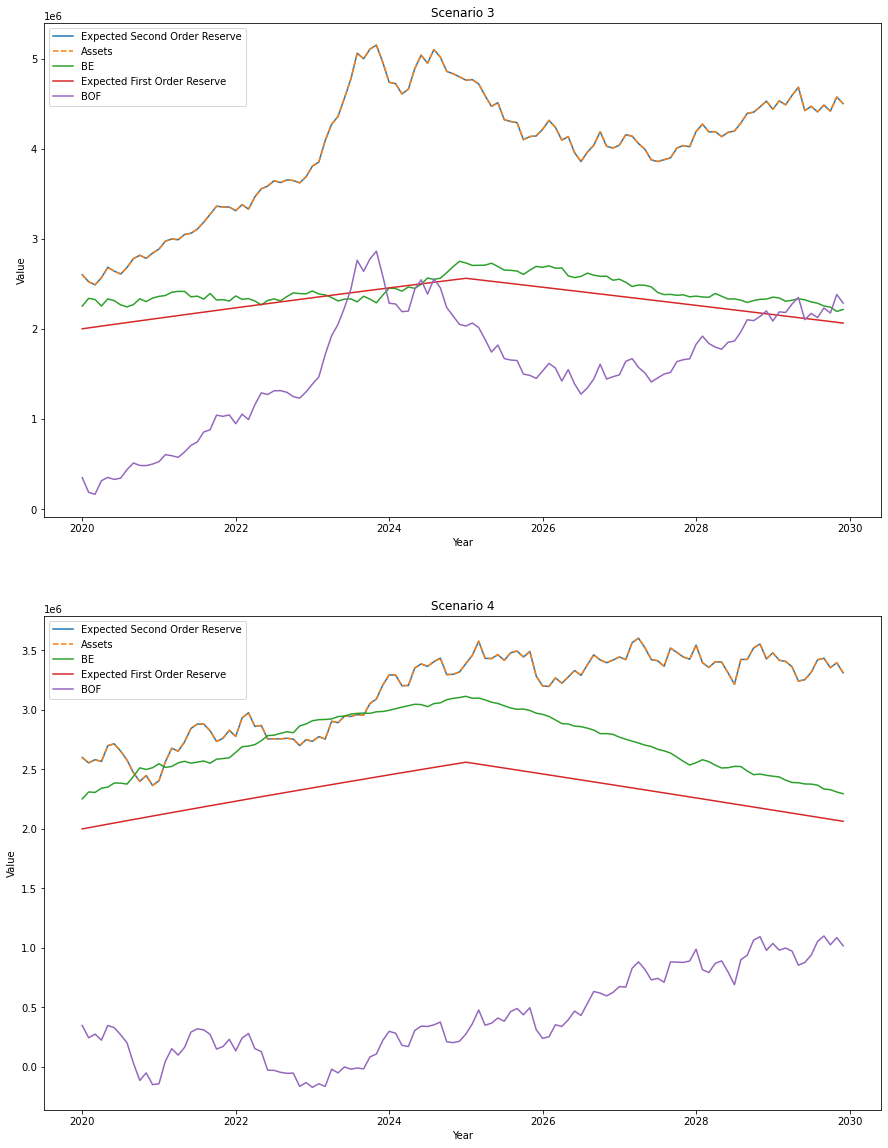

In [24]:
## Visualize scenarios CM(50/50)
# 3
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])

firstOrderDept = firstOrder(G0, age0, makehamParameters, maxT=120)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(allScenarios[2])
BE3 = firstOrderDept.be

bondPortfolio = portfolio(values,0,allScenarios[2],strategy='c')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets3 = secondOrderDept.assets
expSecondReserve3 = secondOrderDept.expSecondOrderReserve
BOF3 = assets3-BE3

# 4
firstOrderDept.getBE2(allScenarios[3])
BE4 = firstOrderDept.be

bondPortfolio = portfolio(values,0,allScenarios[3],strategy='c')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets4 = secondOrderDept.assets
expSecondReserve4 = secondOrderDept.expSecondOrderReserve
BOF4 = assets4-BE4

fig, axs = plt.subplots(2, 1)

x = np.arange(2020,2030,(1/12))
axs[0].plot(x,expSecondReserve3,label='Expected Second Order Reserve')
axs[0].plot(x,assets3,'--',label='Assets')
axs[0].plot(x,BE3,label='BE')
axs[0].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[0].plot(x,BOF3,label='BOF')
axs[0].set_title('Scenario 3')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Value')
axs[0].legend()

axs[1].plot(x,expSecondReserve4,label='Expected Second Order Reserve')
axs[1].plot(x,assets4,'--',label='Assets')
axs[1].plot(x,BE4,label='BE')
axs[1].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[1].plot(x,BOF4,label='BOF')
axs[1].set_title('Scenario 4')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Value')
axs[1].legend()

plt.show()

<h3>d) CM(50/50)-Duration</h3>

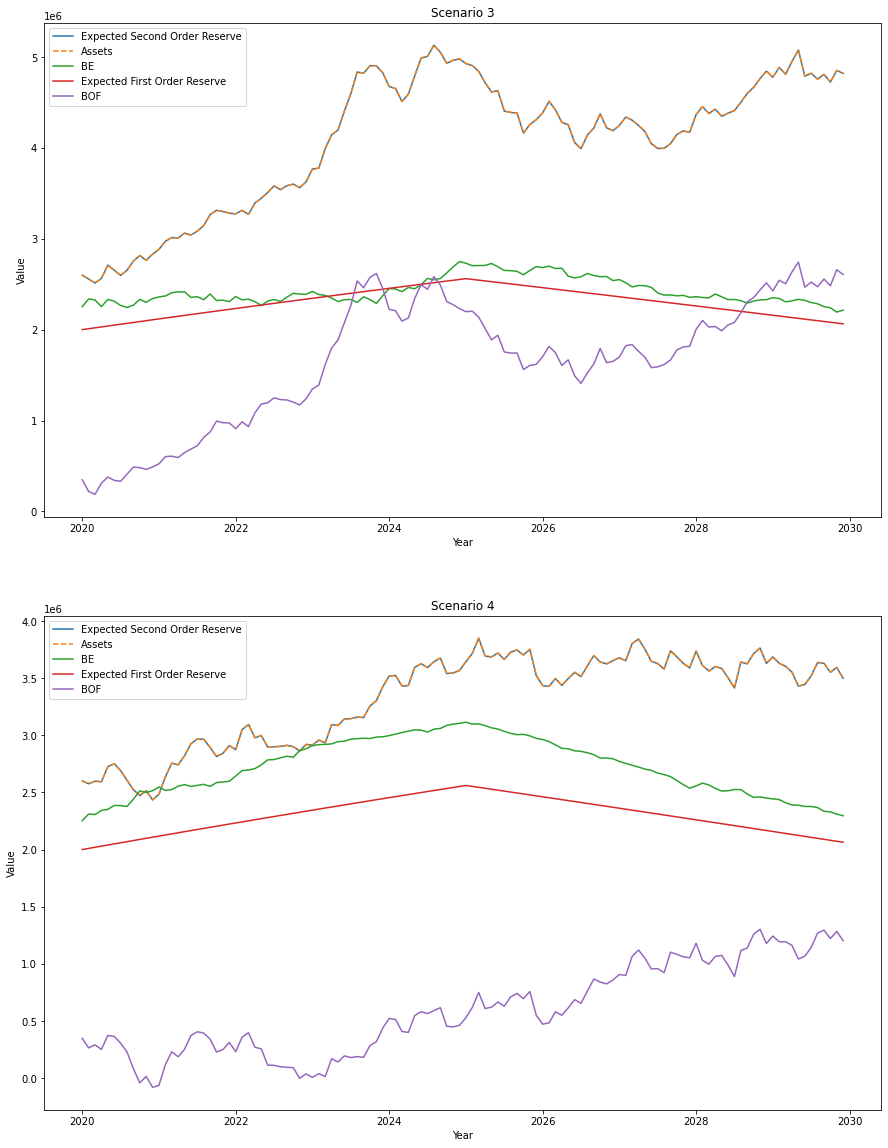

In [25]:
## Visualize scenarios CM(50/50)-Duration
# 3
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])

firstOrderDept = firstOrder(G0, age0, makehamParameters, maxT=120)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(allScenarios[2])
BE3 = firstOrderDept.be
firstOrderDept.getBE()
durationBE = firstOrderDept.beD

bondPortfolio = portfolio(values,0,allScenarios[2],strategy='d', duration=durationBE)
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets3 = secondOrderDept.assets
expSecondReserve3 = secondOrderDept.expSecondOrderReserve
BOF3 = assets3-BE3

# 4
firstOrderDept.getBE2(allScenarios[3])
BE4 = firstOrderDept.be

bondPortfolio = portfolio(values,0,allScenarios[3],strategy='d', duration=durationBE)
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=120)
assets4 = secondOrderDept.assets
expSecondReserve4 = secondOrderDept.expSecondOrderReserve
BOF4 = assets4-BE4

fig, axs = plt.subplots(2, 1)

x = np.arange(2020,2030,(1/12))
axs[0].plot(x,expSecondReserve3,label='Expected Second Order Reserve')
axs[0].plot(x,assets3,'--',label='Assets')
axs[0].plot(x,BE3,label='BE')
axs[0].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[0].plot(x,BOF3,label='BOF')
axs[0].set_title('Scenario 3')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Value')
axs[0].legend()

axs[1].plot(x,expSecondReserve4,label='Expected Second Order Reserve')
axs[1].plot(x,assets4,'--',label='Assets')
axs[1].plot(x,BE4,label='BE')
axs[1].plot(x,expFirstReserve,label='Expected First Order Reserve')
axs[1].plot(x,BOF4,label='BOF')
axs[1].set_title('Scenario 4')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Value')
axs[1].legend()

plt.show()

<h2>Stress test</h2>

In [26]:
# adjust DF
df = pd.read_csv('data/market_data.csv',sep=';')
df['Date'] = pd.to_datetime(df.Date)
df = df[df['Date']<pd.to_datetime('2009-01-01')]
df = df[df['Date']>pd.to_datetime('2007-12-28')]
df.index = range(len(df.index))
df.insert(1, 'Period', df.index)

In [27]:
# Create scenarios
data = df.iloc[[0,4,8,12,17,21,26,30,34,39,43,47,52]]
data.index = range(len(data.index))
data = data.drop('Period',1)
data.insert(1, 'Period', data.index)
scenario = scenarioHandler(data, estNS=True)
scenario = scenarioHandler(data)

In [28]:
#a) BE(0/100)
firstOrderDept = firstOrder(G0, age0, makehamParameters)
expFirstReserve = firstOrderDept.expReserve
firstOrderDept.getBE2(scenario,12)
BE = firstOrderDept.be

In [29]:
bondPortfolio = portfolio(V0,0,scenario,strategy='a')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, bondPortfolio, expFirstReserve, maxT=12)
assets = secondOrderDept.assets
expSecondReserve = secondOrderDept.expSecondOrderReserve
BOF = assets-BE[:12]
deltaBOF = BOF[-1] - BOF[0]
# print(deltaBOF)

In [30]:
stockvValues = np.ones(10) *((V0/2)/10)
values = np.append(stockvValues,[V0/2])
Portfolio = portfolio(values,0,scenario,strategy='b')
secondOrderDept = secondOrder2(V0, age0, makehamParameters, Portfolio, expFirstReserve, maxT=12)
assets = secondOrderDept.assets
expSecondReserve = secondOrderDept.expSecondOrderReserve
BOF = assets-BE[:12]
deltaBOF = BOF[11] - BOF[0]
# print(deltaBOF)

<h3>BH(0/100): ∆BOF=-58 956 <br>
BH(50/50): ∆BOF=-550 742 </h3>